# Explainable AI: Grad-CAM and Score-CAM Visualization

This notebook demonstrates:
1. Training a pretrained CNN (ResNet18) on CIFAR-10
2. Grad-CAM visualization to understand model predictions
3. Score-CAM visualization for comparison

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. Data Loading and Preprocessing

CIFAR-10 consists of 60,000 32x32 color images in 10 classes.

In [3]:
# CIFAR-10 classes
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Transforms for training (with augmentation)
transform_train = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transforms for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download and load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:43<00:00, 3.91MB/s]


Training samples: 50000
Test samples: 10000


## 2. Model Setup

We use a pretrained ResNet18 and modify the final fully connected layer for CIFAR-10 (10 classes).

In [4]:
def create_model():
    """Create a ResNet18 model pretrained on ImageNet, modified for CIFAR-10."""
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Freeze early layers (optional - for faster training)
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    
    # Unfreeze the last residual block and fc layer for fine-tuning
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True
    
    return model

model = create_model().to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3. Training Pipeline

In [5]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(trainloader), 100. * correct / total


def evaluate(model, testloader, criterion, device):
    """Evaluate the model on test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(testloader), 100. * correct / total

In [6]:
# Training hyperparameters
NUM_EPOCHS = 5  # Increase for better results
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    scheduler.step()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch 1/5: Train Loss: 0.4449, Train Acc: 84.55% | Test Loss: 0.3333, Test Acc: 88.49%
Epoch 2/5: Train Loss: 0.2613, Train Acc: 90.99% | Test Loss: 0.3062, Test Acc: 89.71%
Epoch 3/5: Train Loss: 0.1905, Train Acc: 93.47% | Test Loss: 0.3176, Test Acc: 89.38%
Epoch 4/5: Train Loss: 0.0868, Train Acc: 97.22% | Test Loss: 0.2315, Test Acc: 92.39%
Epoch 5/5: Train Loss: 0.0572, Train Acc: 98.22% | Test Loss: 0.2305, Test Acc: 92.52%


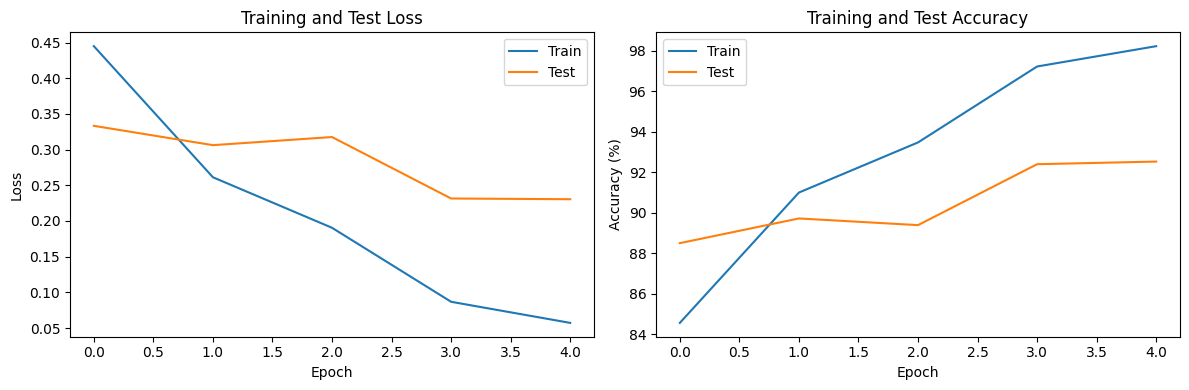

In [7]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train')
ax1.plot(test_losses, label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()

ax2.plot(train_accs, label='Train')
ax2.plot(test_accs, label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. CAM Visualization Utilities

In [8]:
def get_original_image(dataset, idx):
    """Get original image without normalization for visualization."""
    transform_viz = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    # Access raw PIL image
    img, label = dataset.data[idx], dataset.targets[idx]
    from PIL import Image
    img_pil = Image.fromarray(img)
    img_tensor = transform_viz(img_pil)
    return img_tensor.permute(1, 2, 0).numpy(), label


def get_normalized_image(dataset, idx):
    """Get normalized image for model input."""
    img, label = dataset[idx]
    return img.unsqueeze(0), label

## 5. Grad-CAM Visualization

**Grad-CAM (Gradient-weighted Class Activation Mapping)** uses the gradients flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting a concept.

In [9]:
# Select target layer for CAM (last convolutional layer in ResNet18)
target_layers = [model.layer4[-1]]

# Create Grad-CAM instance
grad_cam = GradCAM(model=model, target_layers=target_layers)

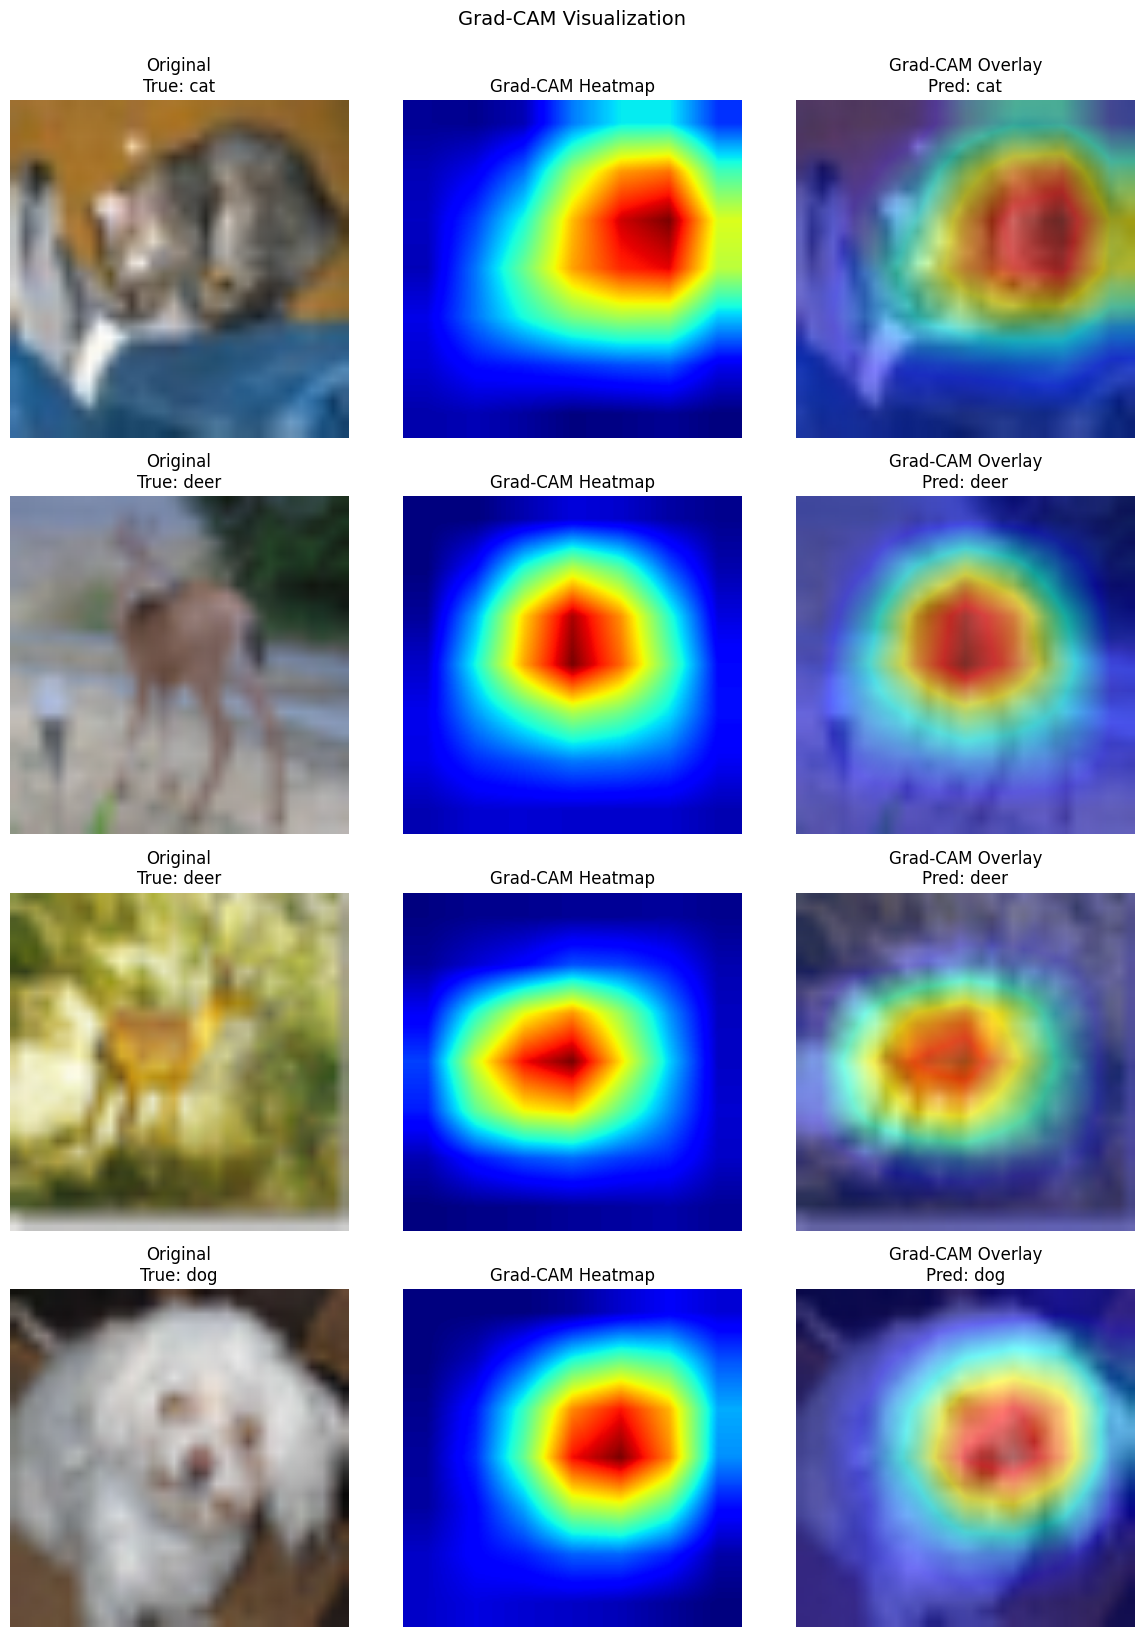

In [10]:
def visualize_gradcam(model, dataset, indices, grad_cam):
    """Visualize Grad-CAM for multiple images."""
    model.eval()
    n_images = len(indices)
    fig, axes = plt.subplots(n_images, 3, figsize=(12, 4 * n_images))
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Get images
        rgb_img, true_label = get_original_image(dataset, idx)
        input_tensor, _ = get_normalized_image(dataset, idx)
        input_tensor = input_tensor.to(device)
        
        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_label = output.argmax(dim=1).item()
        
        # Generate Grad-CAM
        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = grad_cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        # Overlay CAM on image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Plot
        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f'Original\nTrue: {CLASSES[true_label]}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(grayscale_cam, cmap='jet')
        axes[i, 1].set_title('Grad-CAM Heatmap')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(visualization)
        axes[i, 2].set_title(f'Grad-CAM Overlay\nPred: {CLASSES[pred_label]}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Grad-CAM Visualization', y=1.02, fontsize=14)
    plt.show()

# Visualize Grad-CAM for sample images
sample_indices = [0, 100, 500, 1000]
visualize_gradcam(model, testset, sample_indices, grad_cam)

## 6. Score-CAM Visualization

**Score-CAM** is a gradient-free CAM method that uses the increase in confidence score when masking the input with each activation map as weights. This avoids the noise that can be present in gradient-based methods.

In [11]:
# Create Score-CAM instance
score_cam = ScoreCAM(model=model, target_layers=target_layers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.32it/s]


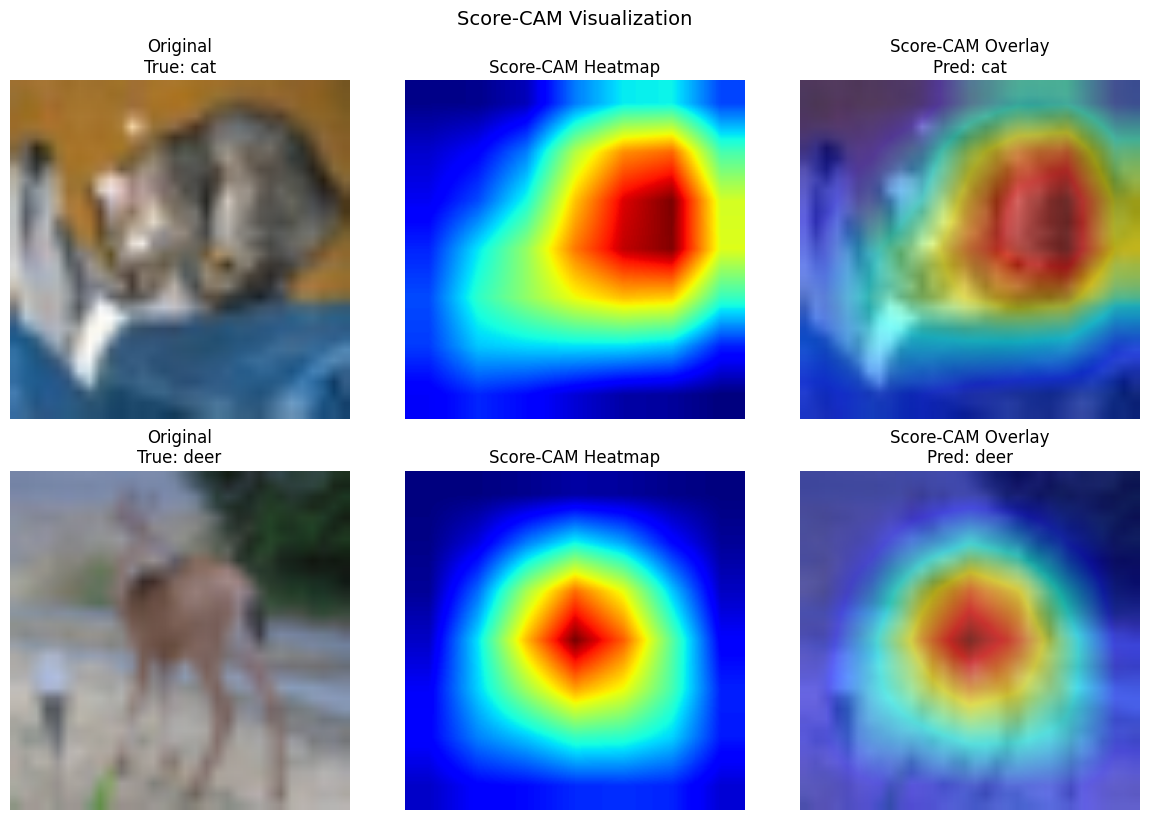

In [12]:
def visualize_scorecam(model, dataset, indices, score_cam):
    """Visualize Score-CAM for multiple images."""
    model.eval()
    n_images = len(indices)
    fig, axes = plt.subplots(n_images, 3, figsize=(12, 4 * n_images))
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Get images
        rgb_img, true_label = get_original_image(dataset, idx)
        input_tensor, _ = get_normalized_image(dataset, idx)
        input_tensor = input_tensor.to(device)
        
        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_label = output.argmax(dim=1).item()
        
        # Generate Score-CAM
        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = score_cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        # Overlay CAM on image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Plot
        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f'Original\nTrue: {CLASSES[true_label]}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(grayscale_cam, cmap='jet')
        axes[i, 1].set_title('Score-CAM Heatmap')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(visualization)
        axes[i, 2].set_title(f'Score-CAM Overlay\nPred: {CLASSES[pred_label]}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Score-CAM Visualization', y=1.02, fontsize=14)
    plt.show()

# Visualize Score-CAM for sample images (Note: Score-CAM is slower than Grad-CAM)
sample_indices = [0, 100]
visualize_scorecam(model, testset, sample_indices, score_cam)

## 7. Comparison: Grad-CAM vs Score-CAM

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.22it/s]


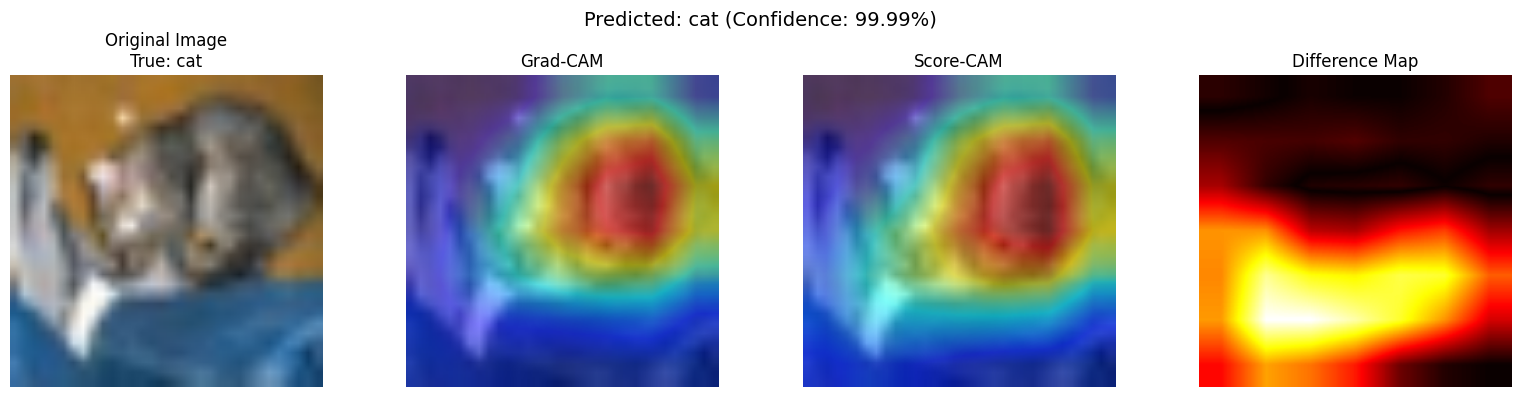

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.33it/s]


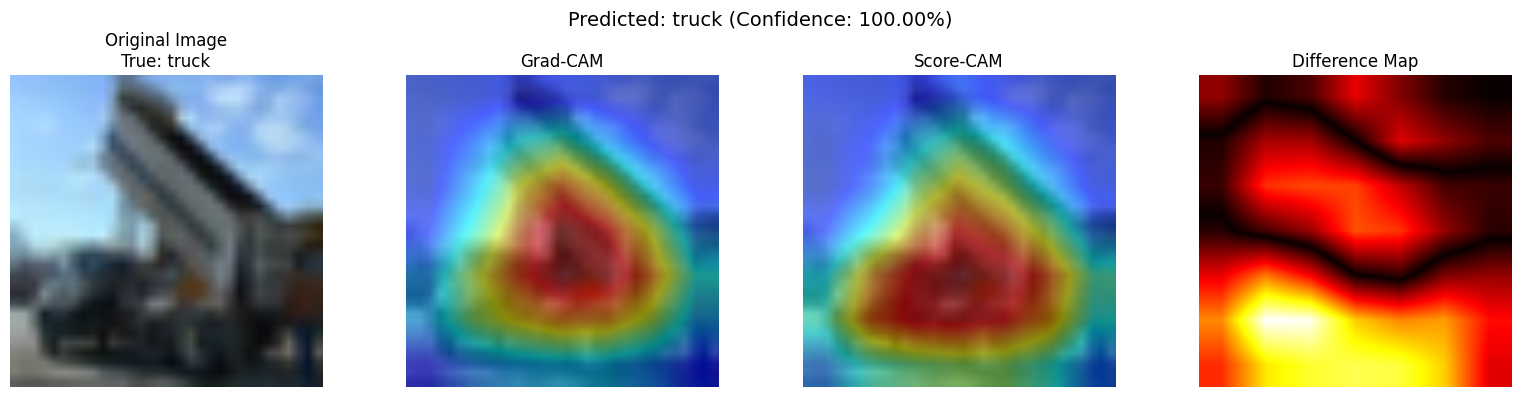

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.29it/s]


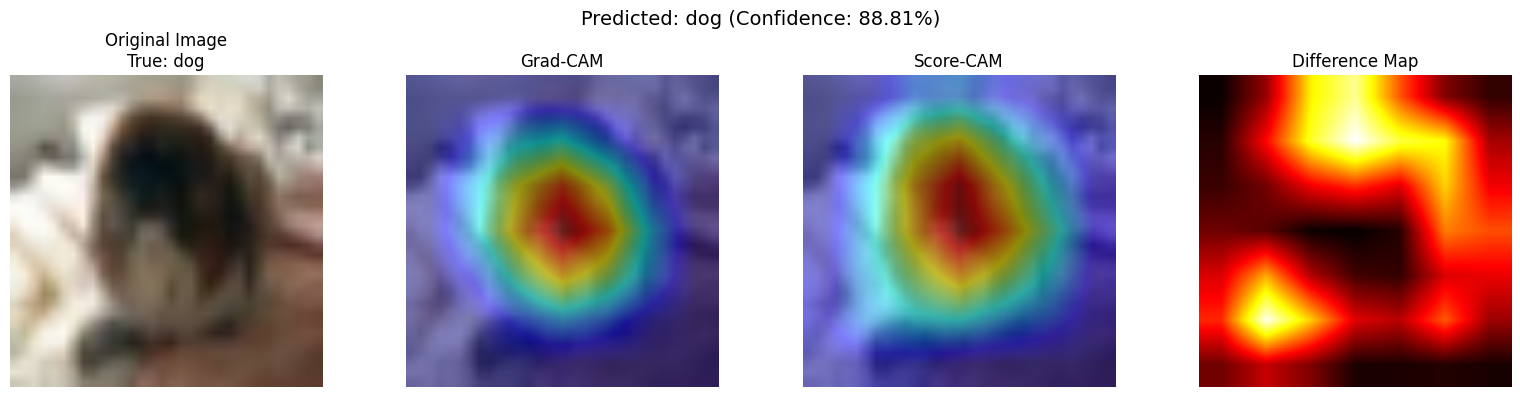

In [13]:
def compare_cam_methods(model, dataset, idx, grad_cam, score_cam):
    """Compare Grad-CAM and Score-CAM side by side."""
    model.eval()
    
    # Get images
    rgb_img, true_label = get_original_image(dataset, idx)
    input_tensor, _ = get_normalized_image(dataset, idx)
    input_tensor = input_tensor.to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred_label = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0, pred_label].item()
    
    targets = [ClassifierOutputTarget(pred_label)]
    
    # Generate both CAMs
    grad_cam_result = grad_cam(input_tensor=input_tensor, targets=targets)[0, :]
    score_cam_result = score_cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # Create visualizations
    grad_viz = show_cam_on_image(rgb_img, grad_cam_result, use_rgb=True)
    score_viz = show_cam_on_image(rgb_img, score_cam_result, use_rgb=True)
    
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(rgb_img)
    axes[0].set_title(f'Original Image\nTrue: {CLASSES[true_label]}')
    axes[0].axis('off')
    
    axes[1].imshow(grad_viz)
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')
    
    axes[2].imshow(score_viz)
    axes[2].set_title('Score-CAM')
    axes[2].axis('off')
    
    # Difference map
    diff = np.abs(grad_cam_result - score_cam_result)
    axes[3].imshow(diff, cmap='hot')
    axes[3].set_title('Difference Map')
    axes[3].axis('off')
    
    plt.suptitle(f'Predicted: {CLASSES[pred_label]} (Confidence: {confidence:.2%})', fontsize=14)
    plt.tight_layout()
    plt.show()

# Compare methods on a few images
for idx in [0, 50, 200]:
    compare_cam_methods(model, testset, idx, grad_cam, score_cam)

## Summary

### Key Differences:

| Method | Approach | Speed | Characteristics |
|--------|----------|-------|------------------|
| **Grad-CAM** | Gradient-based | Fast | Uses gradients; can be noisy |
| **Score-CAM** | Gradient-free | Slower | Uses forward passes; smoother results |

### When to Use Each:
- **Grad-CAM**: Good for quick analysis and when computation time matters
- **Score-CAM**: Better for detailed analysis and when gradient noise is a concern